# Imports

In [168]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from PIL import Image
from skimage import img_as_float, exposure
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from math import floor
from random import choice
import warnings
warnings.filterwarnings('ignore')

# Constant definitions

In [169]:
IMG_SHAPE = (128, 256)
NUM_OF_IMAGES = 8940
COLOR_VALUES = ['šedá-metalíza', 'béžová-metalíza', 'modrá-metalíza', 'bílá', 'hnědá-metalíza', 'zelená-metalíza', 'šedá', 'černá-metalíza', 'černá', 'červená', 'oranžová-metalíza', 'červená-metalíza', 'stříbrná-metalíza', 'modrá', 'hnědá', 'bílá-metalíza', 'stříbrná', 'zelená', 'žlutá', 'zlatá-metalíza', 'žlutá-metalíza', 'fialová', 'fialová-metalíza', 'vínová-metalíza', 'béžová', 'oranžová', 'zlatá', '-metalíza', 'vínová']

# Removing outlier images
- Images were walked through manually and determined as outliers
- outlier images included tyres and car documentation

In [170]:
outlier_images = [8801, 7896, 6921, 6451, 6322, 6301, 6268, 6224, 6205, 6179, 6156, 6162]

# Util functions

In [171]:
def get_image_data(filename, path):
    '''
    Given filename return normalized, resized
    img data, car_id and color_id
    '''
    img = load_img(path + '/' + filename).resize((IMG_SHAPE[1],IMG_SHAPE[0]))
    input_data = img_to_array(img)/255.0
    car_id, color_id = filename[:-4].split('_')
    return car_id, input_data, color_id



In [172]:
def get_image_hist(filename, path):
    '''
    Given a filename and path return resized histogram of car image data
    and car_id, color_id
    '''
    img = load_img(path + '/' + filename).resize((128,96))
    img = img_as_float(img)
    car_id, color_id = filename[:-4].split('_')

    hi_r = exposure.histogram(img[:,:,0])
    hi_g = exposure.histogram(img[:,:,1])
    hi_b = exposure.histogram(img[:,:,2])
    hist = np.concatenate((hi_r[0], hi_g[0], hi_b[0]))/(IMG_SHAPE[0]*IMG_SHAPE[1])
    
    return car_id, hist, color_id

In [173]:
def load_data(hist=False):
    '''
    Walk through all images in assets folder and return dataframe with data, car_ids and targets
    '''
    df = pd.DataFrame({'car_id': pd.Series([], dtype='int'),
                   'img': pd.Series([], dtype='object'),
                   'color': pd.Series([], dtype='str'),    
                   'color_id': pd.Series([], dtype='int')})
    path = 'assets'
    indices = []
    for el in os.listdir('assets'):
        el = el.split('_')
        if int(el[0]) not in outlier_images:
            indices.append((el[0], el[1][:-4]))
    for i, idx in enumerate(indices):
        filename = f'{idx[0]}_{idx[1]}.png'
        if hist:
            img_id, x, y = get_image_hist(filename, path)
        else:
            img_id, x, y = get_image_data(filename, path)
        df = df.append({'car_id': int(img_id), 'img': x, 'color': str(COLOR_VALUES[int(y)]), 'color_id': int(y)}, ignore_index=True)
    return df

In [174]:
def plot_confusion_matrix(cm, labels):
    '''
    Given confusion matrix and labels create plot
    '''
    cmd = ConfusionMatrixDisplay(cm, display_labels=[NEW_COLOR_VALUES[el] for el in labels])
    cmd.plot(xticks_rotation='vertical')
    cmd.ax_.set(xlabel='Predicted', ylabel='True')
    plt.show()

In [175]:
def balance_on_min_class(df, multiple):
    classes = sorted(df['color_id'].unique())
    count_classes = pd.value_counts(df['color_id'], sort=True)
    MIN = multiple*count_classes.iloc[-1]
    indices = []
    for el in classes:
        subset = df[df['color_id'] == el]
        for _ in range(MIN):
            idx = choice(subset.index)
            indices.append(idx)
    return df.loc[indices]

In [176]:
import random
random.seed(123)

# Data loading and analysis

In [177]:
df = load_data(hist=True)

In [178]:
df

,car_id,img,color,color_id
0,0,"[3.0517578125e-05, 6.103515625e-05, 0.00012207...",šedá-metalíza,0
1,1000,"[0.000946044921875, 0.000274658203125, 0.00030...",černá-metalíza,7
2,1001,"[0.002899169921875, 0.000823974609375, 0.00109...",černá-metalíza,7
3,1002,"[0.00030517578125, 6.103515625e-05, 6.10351562...",šedá-metalíza,0
4,1003,"[3.0517578125e-05, 6.103515625e-05, 0.00015258...",šedá-metalíza,0
...,...,...,...,...
8923,997,"[3.0517578125e-05, 9.1552734375e-05, 3.0517578...",šedá-metalíza,0
8924,998,"[3.0517578125e-05, 0.0, 0.0, 0.0, 0.0, 6.10351...",černá-metalíza,7
8925,999,"[3.0517578125e-05, 6.103515625e-05, 0.00012207...",bílá,3
8926,99,"[3.0517578125e-05, 3.0517578125e-05, 0.0001831...",bílá,3


## Plot occurence of classes in dataset

Text(0.5, 1.0, 'Distribution of car colors')

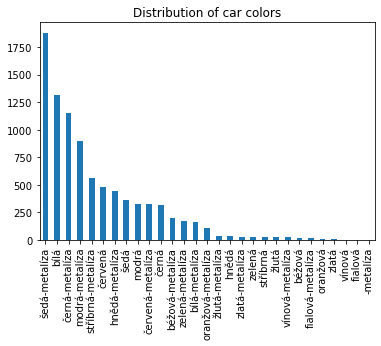

In [179]:
count_classes = pd.value_counts(df['color'], sort=True)
count_classes.plot(kind='bar')
plt.title('Distribution of car colors')

# Grouping together similar colors
- šedá-metalíza => šedá
- modrá-metalíza => modrá etc.
- béžová, stříbrná => šedá

In [180]:
# NEW_COLOR_VALUES = ['šedá', 'béžová', 'modrá', 'bílá', 'hnědá', 'zelená', 'černá', 'červená', 'oranžová', 'stříbrná', 'žlutá', 'zlatá', 'fialová', 'vínová', 'metalíza']
# COLOR_CONVERTER = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:0, 7:6, 8:6, 9:7, 10:8, 11:7, 12:9, 13:2, 14:4, 15:3, 16:9, 17:5, 18:10, 19:11, 20:10, 21:12, 22:12, 23:13, 24:1, 25:8, 26:11, 27:14, 28:13}

NEW_COLOR_VALUES = ['šedá', 'modrá', 'bílá' , 'hnědá', 'zelená' , 'černá', 'červená' , 'oranžová', 'žlutá' , 'zlatá', 'fialová' , 'vínová', 'metalíza']
COLOR_CONVERTER = {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:0, 7:5, 8:5, 9:9, 10:7, 11:6, 12:0, 13:1, 14:3, 15:2, 16:0, 17:4, 18:8, 19:9, 20:8, 21:10, 22:10, 23:11, 24:0, 25:7, 26:9, 27:12, 28:11}


In [181]:
df['color_id'] = df['color_id'].map(COLOR_CONVERTER)
df['color'] = df['color_id'].map({val:col for val, col in enumerate(NEW_COLOR_VALUES)})

## Plot occurence of classes in merged colors dataset 

Text(0.5, 1.0, 'Distribution of car colors')

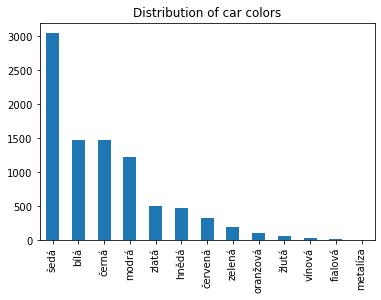

In [182]:
count_classes = pd.value_counts(df['color'], sort=True)
count_classes.plot(kind='bar')
plt.title('Distribution of car colors')

In [183]:
count_classes

šedá        3045
bílá        1473
černá       1473
modrá       1226
zlatá        508
hnědá        476
červená      320
zelená       199
oranžová     108
žlutá         60
vínová        26
fialová       13
metalíza       1
Name: color, dtype: int64

## Cutting out classes with small number of occurences

In [184]:
frequent_colors = count_classes[count_classes > 200]
df = df[df['color'].isin(frequent_colors.index)]

Text(0.5, 1.0, 'Distribution of car colors')

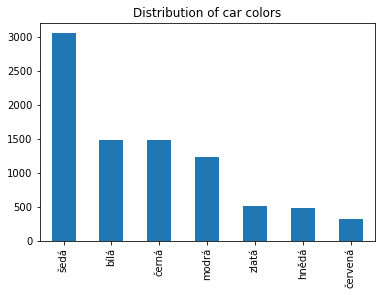

In [185]:
count_classes = pd.value_counts(df['color'], sort=True)
count_classes.plot(kind='bar')
plt.title('Distribution of car colors')

# Data splitting

## Get features and targets

In [186]:
rest = df[['car_id', 'color', 'color_id']]
X = pd.DataFrame(df['img'])
y = pd.DataFrame(df['color_id'])
X = pd.DataFrame(np.stack([el.flatten() for el in X['img']], axis=0), index=y.index) #flatten image data

Text(0.5, 1.0, 'Distribution of car colors')

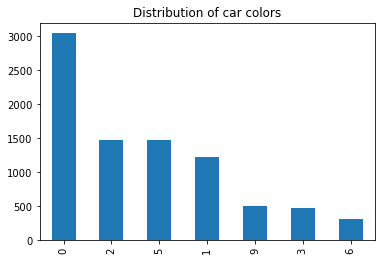

In [187]:
count_classes = pd.value_counts(y['color_id'], sort=True)
count_classes.plot(kind='bar')
plt.title('Distribution of car colors')

## Split into train, val, test sets

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

# Experiments

## KNN experiment

In [189]:
# Test different values of k

values = dict()
for k in range(1, 100, 5):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    predictions = neigh.predict(X_val)
    acc = accuracy_score(y_val, predictions)
    values[k] = acc

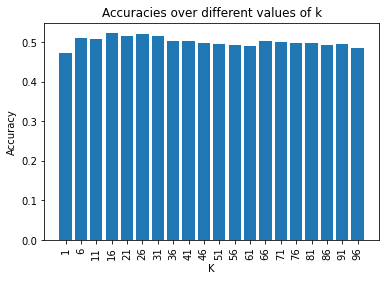

In [190]:
# Plot accuracy based on k

plt.bar(range(len(values)), list(values.values()), align='center')
plt.xticks(range(len(values)), list(values.keys()))
plt.xticks(rotation=90)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracies over different values of k")
plt.show()

k = 15, test accuracy = 0.5293197810789679



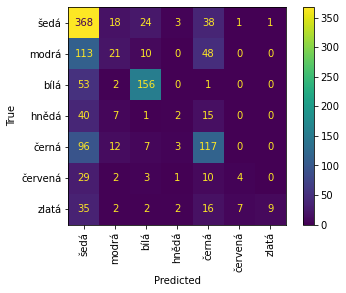

classification report:
              precision    recall  f1-score   support

           0       0.50      0.81      0.62       453
           1       0.33      0.11      0.16       192
           2       0.77      0.74      0.75       212
           3       0.18      0.03      0.05        65
           5       0.48      0.50      0.49       235
           6       0.33      0.08      0.13        49
           9       0.90      0.12      0.22        73

    accuracy                           0.53      1279
   macro avg       0.50      0.34      0.35      1279
weighted avg       0.52      0.53      0.48      1279




In [191]:
# Analyze results

labels = sorted(df['color_id'].unique())
k = 15
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"k = {k}, test accuracy = {acc}\n")
cm = confusion_matrix(y_test, predictions, labels)
plot_confusion_matrix(cm, labels)
cr = classification_report(y_test, predictions)
print(f"classification report:\n{cr}\n")

## Random forest experiment

In [192]:
# Define and run classifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_val)
acc = accuracy_score(y_val, predictions)
print(f"val accuracy = {acc}", end="\n")
predictions = clf.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"test accuracy = {acc}", end="\n")

val accuracy = 0.6689655172413793
test accuracy = 0.6692728694292416


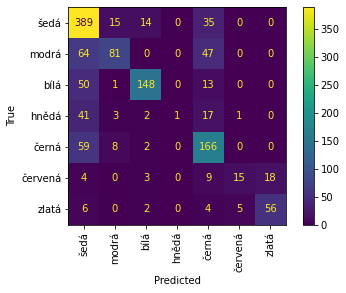

classification report:
              precision    recall  f1-score   support

           0       0.63      0.86      0.73       453
           1       0.75      0.42      0.54       192
           2       0.87      0.70      0.77       212
           3       1.00      0.02      0.03        65
           5       0.57      0.71      0.63       235
           6       0.71      0.31      0.43        49
           9       0.76      0.77      0.76        73

    accuracy                           0.67      1279
   macro avg       0.76      0.54      0.56      1279
weighted avg       0.71      0.67      0.65      1279




In [193]:
# Analyze results

labels = sorted(df['color_id'].unique())
cm = confusion_matrix(y_test, predictions, labels)
plot_confusion_matrix(cm, labels)
cr = classification_report(y_test, predictions)
print(f"classification report:\n{cr}\n")

## Discussion
- Both algorithms seem to perform poorly, 
more specifically they seem to have a strong tendency to predict the most frequent classes
- Fix the problem by resampling the training dataset to get a more balanced distribution

# Balancing dataset

- the dataset is rebalanced by resampling with repretition
- the classes are either upsampled or downsampled, such that every class have exactly n*min_class_occurence

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
y_train = y_train.squeeze()
y_val = y_val.squeeze()
y_test = y_test.squeeze()

In [195]:
# Resampling the data
# experimentally found that n=2 works well

n = 3
df_rebalanced = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
df_rebalanced = balance_on_min_class(df_rebalanced, n)

X_train = df_rebalanced.iloc[:, :768]
y_train = df_rebalanced.iloc[:, 768]

Text(0.5, 1.0, 'Distribution of car colors')

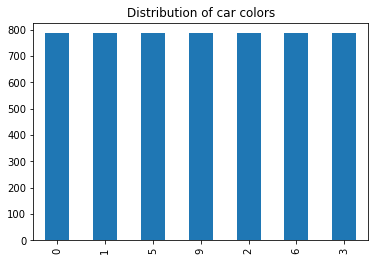

In [196]:
# Plot the distribution of classes in balanced dataset

count_classes = pd.value_counts(y_train, sort=True)
count_classes.plot(kind='bar')
plt.title('Distribution of car colors')

## KNN experiment

In [197]:
# Running different values of k

values = dict()
for k in range(1, 100, 3):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    predictions = neigh.predict(X_val)
    acc = accuracy_score(y_val, predictions)
    values[k] = acc
#     print(f"k = {k}, val accuracy = {acc}", end="\n")

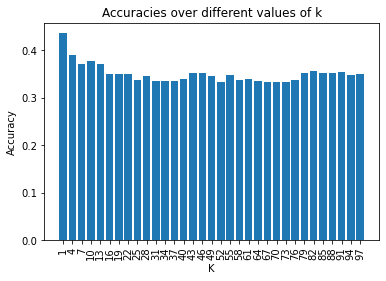

In [198]:
# Plot accuracies based on k

plt.bar(range(len(values)), list(values.values()), align='center')
plt.xticks(range(len(values)), list(values.keys()))
plt.xticks(rotation=90)
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Accuracies over different values of k")
plt.show()

k = 1, test accuracy = 0.43376318874560377



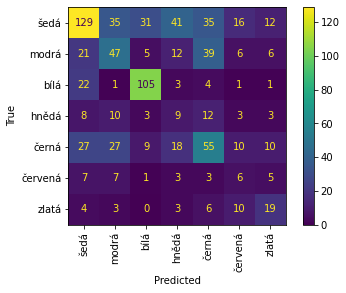

classification report:
              precision    recall  f1-score   support

           0       0.59      0.43      0.50       299
           1       0.36      0.35      0.35       136
           2       0.68      0.77      0.72       137
           3       0.10      0.19      0.13        48
           5       0.36      0.35      0.35       156
           6       0.12      0.19      0.14        32
           9       0.34      0.42      0.38        45

    accuracy                           0.43       853
   macro avg       0.36      0.38      0.37       853
weighted avg       0.47      0.43      0.44       853




In [199]:
# Analyze results

labels = sorted(df['color_id'].unique())
k = 1
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
predictions = neigh.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"k = {k}, test accuracy = {acc}\n")
cm = confusion_matrix(y_test, predictions, labels)
plot_confusion_matrix(cm, labels)
cr = classification_report(y_test, predictions)
print(f"classification report:\n{cr}\n")

## Random forest experiment

In [200]:
# Define and run classifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_val)
acc = accuracy_score(y_val, predictions)
print(f"val accuracy = {acc}", end="\n")
predictions = clf.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"test accuracy = {acc}", end="\n")

val accuracy = 0.6388526727509778
test accuracy = 0.6271981242672919


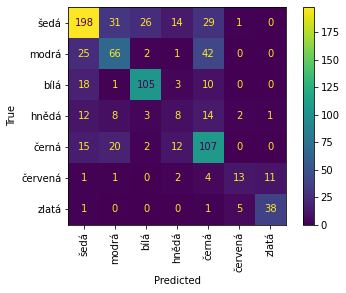

classification report:
              precision    recall  f1-score   support

           0       0.73      0.66      0.70       299
           1       0.52      0.49      0.50       136
           2       0.76      0.77      0.76       137
           3       0.20      0.17      0.18        48
           5       0.52      0.69      0.59       156
           6       0.62      0.41      0.49        32
           9       0.76      0.84      0.80        45

    accuracy                           0.63       853
   macro avg       0.59      0.57      0.57       853
weighted avg       0.63      0.63      0.63       853




In [201]:
# Analyze results

labels = sorted(df['color_id'].unique())
cm = confusion_matrix(y_test, predictions, labels)
plot_confusion_matrix(cm, labels)
cr = classification_report(y_test, predictions)
print(f"classification report:\n{cr}\n")

## XGBoost experiment

In [202]:
import xgboost as xgb
clf = xgb.XGBClassifier(random_state=42)
clf.fit(X_train, y_train)
predictions = clf.predict(X_val)
acc = accuracy_score(y_val, predictions)
print(f"val accuracy = {acc}", end="\n")
predictions = clf.predict(X_test)
acc = accuracy_score(y_test, predictions)
print(f"test accuracy = {acc}", end="\n")

[21:15:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
val accuracy = 0.6962190352020861
test accuracy = 0.6928487690504103


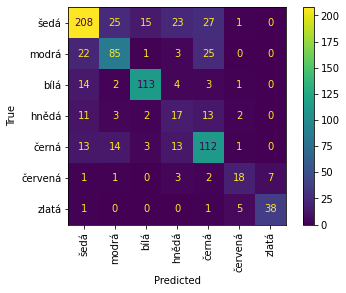

classification report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       299
           1       0.65      0.62      0.64       136
           2       0.84      0.82      0.83       137
           3       0.27      0.35      0.31        48
           5       0.61      0.72      0.66       156
           6       0.64      0.56      0.60        32
           9       0.84      0.84      0.84        45

    accuracy                           0.69       853
   macro avg       0.66      0.66      0.66       853
weighted avg       0.71      0.69      0.70       853




In [203]:
# Analyze results

labels = sorted(df['color_id'].unique())
cm = confusion_matrix(y_test, predictions, labels)
plot_confusion_matrix(cm, labels)
cr = classification_report(y_test, predictions)
print(f"classification report:\n{cr}\n")

## Discussion
- algorithms don't seem to perform much better after resampling
- accuracy about the same
- diagonal slightly better after resampling

## Grid search on Random Forest

In [204]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# y_train = y_train.squeeze()
# y_val = y_val.squeeze()
# y_test = y_test.squeeze()

In [205]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [5, 10, 15],
#     'n_estimators': [100, 200, 500]
# }

# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 3)

In [206]:
# grid_search.fit(X_train, y_train)


In [207]:
# clf = RandomForestClassifier(**grid_search.best_params_)
# clf.fit(X_train, y_train)
# predictions = clf.predict(X_val)
# acc = accuracy_score(y_val, predictions)
# print(f"val accuracy = {acc}", end="\n")
# predictions = clf.predict(X_test)
# acc = accuracy_score(y_test, predictions)
# print(f"test accuracy = {acc}", end="\n")

In [208]:
# labels = sorted(df['color_id'].unique())
# cm = confusion_matrix(y_test, predictions, labels)
# plot_confusion_matrix(cm, labels)
# cr = classification_report(y_test, predictions)
# print(f"classification report:\n{cr}\n")

# Analysis of misclassified examples

In [209]:
df_original = load_data()

In [210]:
y_compare = pd.DataFrame({'y_true': y_test})
y_compare['y_pred'] = predictions

In [211]:
wrongly_classified = y_compare[y_compare['y_true'] != y_compare['y_pred']].index

car id: 5757
true color: šedá
predicted color: modrá


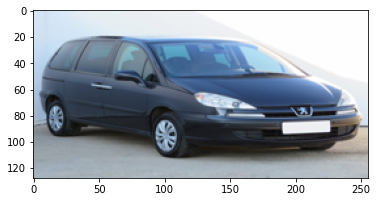

In [233]:
wrong_example = random.choice(wrongly_classified)
print(f"car id: {df_original.loc[wrong_example]['car_id']}")
print(f"true color: {NEW_COLOR_VALUES[y_compare.loc[wrong_example]['y_true']]}")
print(f"predicted color: {NEW_COLOR_VALUES[y_compare.loc[wrong_example]['y_pred']]}")
plt.imshow(df_original.loc[wrong_example]['img']);

## Conclusion
- classifiers performed as well as reasonably possible
- walking through images of missclassified cars show that in some cases:
    - labels are likely incorrect
    - it is very difficult to differentiate between similar colors such as black/blue/gray

# CNN experiments (incomplete)
(ran on imbalanced dataset with original images)

In [ ]:
df = load_data()

In [126]:
rest = df[['car_id', 'color']]
X = pd.DataFrame(df['img'])
y = pd.DataFrame(df['color_id'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

y_train = to_categorical(y_train)
y_train = pd.DataFrame(y_train)
y_val = to_categorical(y_val)
y_val = pd.DataFrame(y_val)
y_test = to_categorical(y_test)
y_test = pd.DataFrame(y_test)

X_train = np.stack([el for el in X_train['img']], axis=0)
X_val = np.stack([el for el in X_val['img']], axis=0)
X_test = np.stack([el for el in X_test['img']], axis=0)

In [135]:
batch_size = 32
num_classes = y_train.shape[1]
epochs = 12

In [136]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(IMG_SHAPE[0],IMG_SHAPE[1],3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [137]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val),
          verbose=1)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
223/223 [==============================] - 360s 2s/step - loss: 2.1083 - accuracy: 0.2256 - val_loss: 1.8754 - val_accuracy: 0.3093
Epoch 2/12
223/223 [==============================] - 333s 1s/step - loss: 1.9298 - accuracy: 0.3176 - val_loss: 1.7642 - val_accuracy: 0.4975
Epoch 3/12
223/223 [==============================] - 329s 1s/step - loss: 1.8247 - accuracy: 0.3665 - val_loss: 1.6847 - val_accuracy: 0.5038
Epoch 4/12
223/223 [==============================] - 327s 1s/step - loss: 1.7516 - accuracy: 0.4039 - val_loss: 1.6235 - val_accuracy: 0.4912
Epoch 5/12
223/223 [==============================] - 320s 1s/step - loss: 1.6795 - accuracy: 0.4362 - val_loss: 1.5688 - val_accuracy: 0.5303
Epoch 6/12
223/223 [==============================] - 319s 1s/step - loss: 1.6636 - accuracy: 0.4388 - val_loss: 1.5394 - val_accuracy: 0.5101
Epoch 7/12
223/223 [==============================] - 342s 2s/step - loss: 1.6240 - accuracy: 0.4562 - val_loss: 1.4993 - val_accuracy: 0.5177

In [389]:
import pickle
filename = 'CNN.sav'
pickle.dump(model, open(filename, 'wb'))

TypeError: cannot pickle 'weakref' object

# Additional ideas
- augment images to create larger dataset
- use pretrained model from TFHub

# Data augmentation


In [227]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

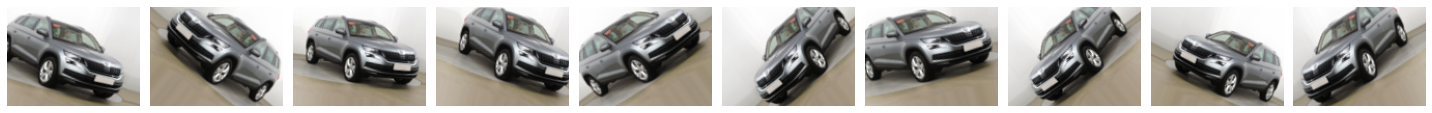

In [280]:
gen = ImageDataGenerator(rotation_range=50, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.15,
                        zoom_range=0.1, horizontal_flip=True)
img = np.expand_dims(img, 0)
aug_iter = gen.flow(img)
aug_images = [next(aug_iter)[0] for i in range(10)]
plotImages(aug_images)

In [394]:
def create_augmented_dataset():
    for _, _, files in os.walk('assets'):
        for filename in files:
            if int(filename.split("_")[0]) not in outlier_images:
                x, car_id, y = get_image_data(str(filename), flatten=False, normalize=True, path='assets')
                x = np.expand_dims(x, 0)
                aug_iter = gen.flow(x)
                aug_images = [next(aug_iter)[0] for i in range(5)]
                i = 0
                for el in aug_images:
                    img = np.array(el*255, dtype=np.uint8)
                    img = Image.fromarray(img)
                    img.save('augmented_images/' + str(car_id) + '_' + str(i) + '_' + str(y) + '.png')
                    i += 1
                img = np.array(x.reshape(IMG_SHAPE[0], IMG_SHAPE[1], 3)*255, dtype=np.uint8)
                img = Image.fromarray(img)
                img.save('augmented_images/' + str(car_id) + '_' + str(i) + '_' + str(y) + '.png')
                
# create_augmented_dataset()

# Experiments on Augmented dataset